In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
pd.set_option('display.max_colwidth', None)

In [2]:
df_reviews = pd.read_csv("data/dataset.csv")

In [30]:
unique_app_names = df_reviews["app_name"].unique()


In [31]:
unique_app_names[0]

'Counter-Strike'

In [67]:
game_reviews = df_reviews[df_reviews["app_name"] == unique_app_names[0]]["review_text"].to_frame()

# Display the first few reviews
print(game_reviews.head())
print(len(game_reviews))

In [68]:
len(game_reviews)

12353

In [69]:
review_counts = df_reviews.groupby("app_name")["review_text"].count().reset_index()
review_counts.columns = ["app_name", "num_reviews"]

# Display sorted results
review_counts = review_counts.sort_values(by="num_reviews", ascending=False)
print(review_counts)

                            app_name  num_reviews
2034                            DayZ        88850
5579                        PAYDAY 2        88783
7776                        Terraria        84702
6541                            Rust        77037
2349                          Dota 2        73433
...                              ...          ...
8050                        The Lost            1
3984  InsanZ - Retro Survival Horror            1
6743                    Second Death            1
6933                    Siege Hammer            1
9359                ルナティックドーン 前途への道標            1

[9363 rows x 2 columns]


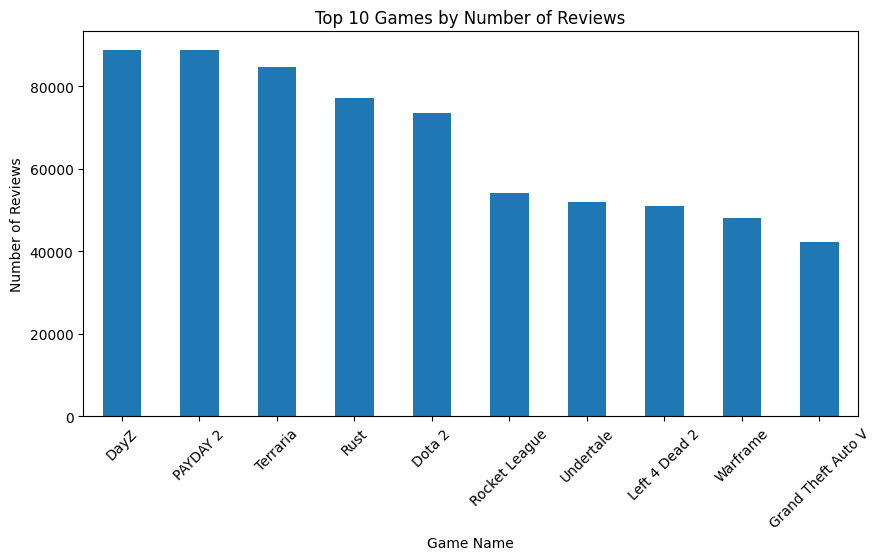

In [4]:
import matplotlib.pyplot as plt

review_counts.head(10).plot(kind="bar", x="app_name", y="num_reviews", figsize=(10, 5), legend=False)
plt.title("Top 10 Games by Number of Reviews")
plt.ylabel("Number of Reviews")
plt.xlabel("Game Name")
plt.xticks(rotation=45)
plt.show()

In [6]:
import re
def clean_text(text):
    if not isinstance(text, str):  # Ensure the text is a string
        return ""  # Return empty string if not a string (e.g., NaN or None)
    # Remove special characters but keep emojis
    text = re.sub(r'[^\w\s,!?\'":;.-]', '', text)  # Removes special chars, leaving emojis
    return text

In [10]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment as Positive, Neutral, or Negative
def classify_sentiment(review):
    cleaned_review = clean_text(review)
    score = sia.polarity_scores(cleaned_review)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply to the reviews
game_reviews['sentiment'] = game_reviews['review_text'].apply(classify_sentiment)

# Display the sentiment for each review
print(game_reviews[['review_text', 'sentiment']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kushp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          review_text  \
68092  You can be a werewolf riding a unicorn while shooting rainbows from a gun. You can build teleporters, find a hair dresser in a spider ca

In [20]:
game_reviews.head(5)

,review_text
68092,"You can be a werewolf riding a unicorn while shooting rainbows from a gun. You can build teleporters, find a hair dresser in a spider cavern, and get a sword that shoots cats. You can take on the lord of the moon using a yoyo, summon a sharknado minion that shoots sharks at your enemies, and find sky temples where air wyverns spawn. You can buy a music box from a wizard and go record the music that you like the most so you can have it playing in your base whenever you want, and then you can go build a castle made entirely out of white marble. It would seem the only thing Minecraft has over this game is 1 dimension. Trust me, once you get used to it and start learning about the game, Terraria is simply one of the most satisfying sandbox experiences out there. It may sound rude, but compared to this, Minecraft just has no imagination."
68093,You should by 8 copies of this game and go around giving it to people who look sad.
68094,Introduction
68095,"If you have friends, this is a great game to play with them. If you don't have any friends, this is a great game to play alone. If you don't have the game to play, get the money for it. If you don't have the money for it, get a job. If you don't have a job, rob the bank. If you get arrested robbing the bank, at least you tried."
68096,A Generic Comparison of Terraria versus Minecraft ≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈ ≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈v≈^≈ ITEMS


In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

c:\Kushwanth\React\kratos-digital-store\ml\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'  # This model outputs ratings from 0 to 4
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

In [71]:
i = 0
def classify_sentiment(review):
    global i
    cleaned_review = clean_text(review)
    i += 1
    # Tokenize the review text
    inputs = tokenizer(cleaned_review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Make predictions using BERT
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Get probabilities for each sentiment (0-4 scale for this model)
    probabilities = softmax(logits, dim=-1)
    
    # Get the sentiment with the highest probability
    sentiment_score = torch.argmax(probabilities, dim=-1).item()
    if i % 100 == 0:
        print(i, sentiment_score)

    # Map the sentiment score to a category
    sentiment_mapping = {
        0: "Very Negative", 
        1: "Mostly Negative", 
        2: "Mixed", 
        3: "Very Positive", 
        4: "Overwhelmingly Positive"
    }
    
    return sentiment_mapping.get(sentiment_score, "Neutral")

In [72]:
len(game_reviews)

12353

In [73]:
# Handle missing reviews (if any)
game_reviews['review_text'] = game_reviews['review_text'].fillna('')

# Apply sentiment classification to each review
game_reviews['sentiment'] = game_reviews['review_text'].apply(classify_sentiment)

# Display the sentiment for each review
print(game_reviews[['review_text', 'sentiment']].head())



100 4
200 4
300 4
400 0
500 4
600 4
700 4
800 4
900 4
1000 4
1100 4
1200 4
1300 4
1400 4
1500 4
1600 4
1700 4
1800 0
1900 4
2000 4
2100 4
2200 4
2300 4
2400 4
2500 4
2600 4
2700 4
2800 4
2900 4
3000 3
3100 4
3200 4
3300 2
3400 4
3500 4
3600 4
3700 4
3800 2
3900 4
4000 2
4100 4
4200 3
4300 4
4400 2
4500 2
4600 3
4700 4
4800 4
4900 1
5000 0
5100 2
5200 4
5300 2
5400 4
5500 4
5600 4
5700 0
5800 4
5900 3
6000 4
6100 3
6200 3
6300 4
6400 4
6500 4
6600 4
6700 4
6800 4
6900 4
7000 4
7100 0
7200 4
7300 3
7400 4
7500 0
7600 4
7700 3
7800 4
7900 1
8000 4
8100 4
8200 2
8300 2
8400 4
8500 4
8600 1
8700 4
8800 4
8900 2
9000 4
9100 2
9200 4
9300 4
9400 0
9500 4
9600 4
9700 4
9800 4
9900 3
10000 0
10100 3
10200 1
10300 4
10400 2
10500 4
10600 0
10700 4
10800 4
10900 3
11000 4
11100 4
11200 4
11300 4
11400 4
11500 3
11600 0
11700 4
11800 4
11900 4
12000 4
12100 4
12200 0
12300 3
                                                                                                                            

In [76]:
overall_sentiment = game_reviews['sentiment'].mode()[0]  # Get the most frequent sentiment
print(f"Overall Sentiment for the Game: {overall_sentiment}")

Overall Sentiment for the Game: Overwhelmingly Positive


In [77]:
game_reviews.head()

,review_text,sentiment
0,Ruined my life.,Very Negative
1,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best games and from that very moment I knew that it is going to be the game I saw at the other friend's house. When I saw the Counter-Strike logo I was filled with gamegasm (?) and I was so happy. I was playing it hardcore. Made friends, clans, was involved in communities and even made two myself. Counter-Strike is my first game which I played competitively and it was a such an experience. Playing public servers with mods were very fun, but playing it competitively made it very intense and stressful. In a pleasant way, ofcourse. Looking at the current e-sport scene it might not seem like much but back then it was different. Shooters these days try to be different, advanced in a way. Sometimes the most simple games like Counter-Strike are the ones that live to this day. Also, there are plenty of mods to keep your attention to this game. The gameplay is very simple - defend as a Counter-Terrorist, attack as a Terrorist to plant the bomb or save the hostages as a CT. I am sure most of you already know this and I doubt there are gamers that haven't heard or know the gameplay of Counter-Strike, so I am sharing here more of my experience. I wish I could find my CS Anthology account which I've lost since 2008. So, I decided I am going to buy this game again and here you go - more than a thousand hours played. I still play it from time to time to this day and it brings back many great memories and I sometimes even stumble upon people I've played with years ago. I think Counter-Strike changed gaming in a major way and we wouldn't have many games like we have today, if this game wouldn't exist. I am sure many of people already have played games like CS:GO but never the roots. I doubt any of you will play it for more than an hour, because it's much more simple and it differs a lot in my opinion from CS:GO and modern games. It's harder though.",Mixed
2,This game saved my virginity.,Overwhelmingly Positive
3,• Do you like original games? • Do you like games that don't lag? • Do you like games you can run on low end PC's? • Do you like games where you don't meet children who have slept with your mother? Then this is for you!,Overwhelmingly Positive
4,"Easy to learn, hard to master.",Very Positive


In [82]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Clean the text data
game_reviews['cleaned_review'] = game_reviews['review_text'].apply(clean_text)

# Tokenize the reviews
X = game_reviews['cleaned_review']
y = game_reviews['sentiment']

# Encode labels (sentiments) into numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenize text data (convert text to sequences of integers)
tokenizer = Tokenizer(num_words=10000)  # Limit to 10,000 most frequent words
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform input length
max_sequence_length = 100  # Adjust as needed
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

# Convert to numpy arrays
X_padded = np.array(X_padded)
y_encoded = np.array(y_encoded)

In [83]:
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch processing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [84]:
import torch.nn as nn
import torch.optim as optim

class SentimentAnalysisModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, max_len):
        super(SentimentAnalysisModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_len] -> [batch_size, seq_len, embedding_dim]
        x, (ht, ct) = self.lstm(x)  # Output from LSTM
        x = self.dropout(x)
        x = x[:, -1, :]  # Use the last output from LSTM (for classification)
        x = self.fc(x)  # Pass through the dense layer
        x = self.softmax(x)  # Softmax output
        return x

In [85]:
vocab_size = 10000  # Tokenizer vocab size
embedding_dim = 128
hidden_dim = 128
output_dim = 5  # For 5 sentiment categories
model = SentimentAnalysisModel(vocab_size, embedding_dim, hidden_dim, output_dim, max_sequence_length)

# Display the model architecture
print(model)

SentimentAnalysisModel(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)


In [86]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [87]:
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    # Compute average loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_samples += labels.size(0)
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print the metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break

Epoch [1/40], Train Loss: 1.3436, Train Accuracy: 0.6241, Validation Loss: 1.2777, Validation Accuracy: 0.6405
Epoch [2/40], Train Loss: 1.2739, Train Accuracy: 0.6321, Validation Loss: 1.2756, Validation Accuracy: 0.6405
Epoch [3/40], Train Loss: 1.2729, Train Accuracy: 0.6320, Validation Loss: 1.2751, Validation Accuracy: 0.6397
Epoch [4/40], Train Loss: 1.2723, Train Accuracy: 0.6330, Validation Loss: 1.2748, Validation Accuracy: 0.6397
Epoch [5/40], Train Loss: 1.2731, Train Accuracy: 0.6334, Validation Loss: 1.2746, Validation Accuracy: 0.6397
Epoch [6/40], Train Loss: 1.2720, Train Accuracy: 0.6344, Validation Loss: 1.2744, Validation Accuracy: 0.6397
Epoch [7/40], Train Loss: 1.2718, Train Accuracy: 0.6344, Validation Loss: 1.2734, Validation Accuracy: 0.6413
Epoch [8/40], Train Loss: 1.2708, Train Accuracy: 0.6341, Validation Loss: 1.2726, Validation Accuracy: 0.6413
Epoch [9/40], Train Loss: 1.2697, Train Accuracy: 0.6337, Validation Loss: 1.2719, Validation Accuracy: 0.6413
E

KeyboardInterrupt: 

In [89]:
game_reviews['cleaned_review'] = game_reviews['review_text'].apply(clean_text)
X = game_reviews['cleaned_review']
y = game_reviews['sentiment']

# Encode labels (sentiments) into numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenize text data (convert text to sequences of integers)
tokenizer = Tokenizer(num_words=10000)  # Limit to 10,000 most frequent words
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform input length
max_sequence_length = 100  # Adjust as needed
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

# Split the data into train and test sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Second split: 50% of X_temp for validation, and 50% for testing (from the remaining 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',    # Metric to monitor
                               patience=5,            # Number of epochs with no improvement to wait before stopping
                               verbose=1,            # Print info about early stopping
                               restore_best_weights=True)

from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(5, activation='softmax'))  # Three classes: Positive, Neutral, Negative


optimizer = Adam(learning_rate=0.0001)  # Reduce the learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Summary of the model architecture
model.summary()


c:\Kushwanth\React\kratos-digital-store\ml\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Train the model
history = model.fit(X_train, y_train,epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 65s 388ms/step - accuracy: 0.5703 - loss: 1.3388 - val_accuracy: 0.6413 - val_loss: 1.0654
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 352ms/step - accuracy: 0.6368 - loss: 1.0518 - val_accuracy: 0.6413 - val_loss: 0.9925
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.6307 - loss: 0.9776 - val_accuracy: 0.6551 - val_loss: 0.8932
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 362ms/step - accuracy: 0.6515 - loss: 0.8837 - val_accuracy: 0.6777 - val_loss: 0.8373
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.6737 - loss: 0.8311 - val_accuracy: 0.6931 - val_loss: 0.7968
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7058 - loss: 0.7687 - val_accuracy: 0.7028 - val_loss: 0.7624
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 364ms/step - accuracy: 0.7215 - loss: 0.7292 - val_accuracy: 0.7126 - val_loss: 0.7319
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 362ms/step - accuracy: 0.7339 - loss: 0

In [92]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7731 - loss: 0.6168
Test Accuracy: 0.7540
Test Loss: 0.6523


In [ ]:
# Predict sentiment for a new review
new_review = ["I had no fun playing this."]
new_review_seq = tokenizer.texts_to_sequences(new_review)
new_review_padded = pad_sequences(new_review_seq, maxlen=max_sequence_length, padding='post')

# Predict the sentiment
prediction = model.predict(new_review_padded)

# Convert prediction to label
predicted_class = label_encoder.inverse_transform([prediction.argmax()])

print(f"Predicted sentiment: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted sentiment: Mixed
